In [1]:
from transformers import GPT2Tokenizer
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
tokenizer=GPT2Tokenizer.from_pretrained('gpt2')
vocab=tokenizer.get_vocab()
vocab_size=len(vocab)
encoder = lambda string: torch.tensor(tokenizer.encode(string), dtype=torch.long,device=device)
decoder = lambda t: tokenizer.decode(t.tolist()) if isinstance(t, torch.Tensor) else tokenizer.decode(t)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [3]:
batch_size=16
context_size=720
n_embd=720
n_heads=12
dropout=0.2
head_size=n_embd//n_heads
device='cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
dataset=open('/kaggle/input/datasetwtw4/dataset.txt').read()

In [5]:
class head(nn.Module):
    def __init__(self):
        super().__init__()
        B,T=batch_size,context_size
        self.key=nn.Linear(n_embd,head_size,bias=False)
        self.query=nn.Linear(n_embd,head_size,bias=False)
        self.value=nn.Linear(n_embd,head_size,bias=False)
        self.register_buffer('tril',torch.tril(torch.ones(T,T)))
    def forward(self,m):
        B,T,C=m.shape
        k=self.key(m)
        q=self.query(m)
        v=self.value(m)
        wei=q@k.transpose(-2,-1)*n_embd**-0.5
        wei=wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei=F.softmax(wei,dim=-1)
        out=wei@v
        return out

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.heads=nn.ModuleList([head() for _ in range(n_heads)])
        self.dropout=nn.Dropout(dropout)
        self.proj=nn.Linear(n_embd,n_embd)
    def forward(self,x):
        out=torch.cat([h(x) for h in self.heads],dim=-1)
        return self.dropout(self.proj(out))

In [7]:
class forwardmethod(nn.Module):
    def __init__(self):
        super().__init__()
        self.ffwd=nn.Sequential(
                nn.Linear(in_features=n_embd,out_features=4*n_embd),
                nn.ReLU(),
                nn.Linear(4*n_embd,n_embd),
                nn.Dropout(dropout)
            )
    def forward(self,fm):
        return self.ffwd(fm)

In [8]:
class block(nn.Module):
    def __init__(self):
        super().__init__()
        self.m_head=MultiHeadAttention()
        self.ffwd1=forwardmethod()
        self.ln1=nn.LayerNorm(n_embd)
        self.ln2=nn.LayerNorm(n_embd)
    def forward(self,bl):
        x1=bl+self.m_head(self.ln1(bl))
        x2=bl+self.ffwd1(self.ln2(x1))
        return x2

In [9]:
class veronica_gpt(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb=nn.Embedding(vocab_size,n_embd)
        self.pos_emb=nn.Embedding(context_size,n_embd)
        self.blocks=nn.Sequential(
            block(),
            block(),
            block(),
            block()
        )
        self.lm=nn.Linear(n_embd,vocab_size)
    def forward(self,x,target=None):
        loss=None
        B,T=x.shape
        emb=self.tok_emb(x)+self.pos_emb(torch.arange(T).to(device))
        logits=self.blocks(emb)
        logits=self.lm(logits)
        if target is not None:
            B,T,C=logits.shape
            logits=logits.view(B*T,C)
            loss=F.cross_entropy(logits,target=target.view(B*T))
        return logits,loss
    def generate(self,idx,max_new_token):
        for _ in range(max_new_token): 
            idx_cond=idx[:,-context_size:]
            logits,loss=self(idx_cond.to(device))
            logits=logits[:,-1,:]
            prob=F.softmax(logits,dim=-1)
            idx_next=torch.multinomial(prob,num_samples=1)
            idx=torch.cat([idx,idx_next],dim=1)
        return idx
            
v=veronica_gpt()
v.to(device)

veronica_gpt(
  (tok_emb): Embedding(50257, 720)
  (pos_emb): Embedding(720, 720)
  (blocks): Sequential(
    (0): block(
      (m_head): MultiHeadAttention(
        (heads): ModuleList(
          (0-11): 12 x head(
            (key): Linear(in_features=720, out_features=60, bias=False)
            (query): Linear(in_features=720, out_features=60, bias=False)
            (value): Linear(in_features=720, out_features=60, bias=False)
          )
        )
        (dropout): Dropout(p=0.2, inplace=False)
        (proj): Linear(in_features=720, out_features=720, bias=True)
      )
      (ffwd1): forwardmethod(
        (ffwd): Sequential(
          (0): Linear(in_features=720, out_features=2880, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2880, out_features=720, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((720,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((720,), eps=1e-05, elementwise_affine=True)
 

In [10]:
data=encoder(dataset)
def get_batch():
    idx=torch.randint(0,(len(data)-context_size),(batch_size,))
    x=torch.stack([data[i:i+context_size] for i in idx])
    y=torch.stack([data[i+1:i+context_size+1] for i in idx])
    return x,y

Token indices sequence length is longer than the specified maximum sequence length for this model (338024 > 1024). Running this sequence through the model will result in indexing errors


tensor(5962, device='cuda:0')

In [11]:
optimizer=torch.optim.AdamW(v.parameters(),lr=0.001)

In [12]:
def check():
 print(decoder(v.generate(encoder("she was gpimg im the dark").to(device).unsqueeze(dim=0),max_new_token=200)[0].tolist()))

def size():
    print(sum([p.numel() for p in v.parameters()]))

In [13]:
size()

97850737


In [15]:
losses=[]
for i in range(100):
    x,y=get_batch()
    logits,loss=v(x,y)
    print(i,loss)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 tensor(8.7622, device='cuda:0', grad_fn=<NllLossBackward0>)
1 tensor(7.6904, device='cuda:0', grad_fn=<NllLossBackward0>)
2 tensor(8.2541, device='cuda:0', grad_fn=<NllLossBackward0>)
3 tensor(7.3107, device='cuda:0', grad_fn=<NllLossBackward0>)
4 tensor(7.6148, device='cuda:0', grad_fn=<NllLossBackward0>)
5 tensor(7.4522, device='cuda:0', grad_fn=<NllLossBackward0>)
6 tensor(7.4464, device='cuda:0', grad_fn=<NllLossBackward0>)
7 tensor(7.1512, device='cuda:0', grad_fn=<NllLossBackward0>)
8 tensor(6.8387, device='cuda:0', grad_fn=<NllLossBackward0>)
9 tensor(6.6296, device='cuda:0', grad_fn=<NllLossBackward0>)
10 tensor(6.3353, device='cuda:0', grad_fn=<NllLossBackward0>)
11 tensor(6.2324, device='cuda:0', grad_fn=<NllLossBackward0>)
12 tensor(6.2641, device='cuda:0', grad_fn=<NllLossBackward0>)
13 tensor(5.9691, device='cuda:0', grad_fn=<NllLossBackward0>)
14 tensor(6.1059, device='cuda:0', grad_fn=<NllLossBackward0>)
15 tensor(6.1095, device='cuda:0', grad_fn=<NllLossBackward0>)
16

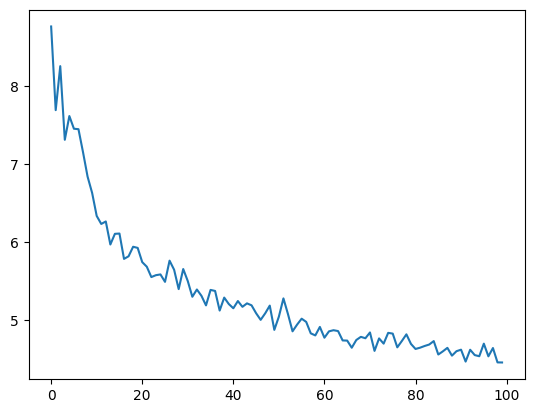

In [18]:
plt.plot(losses)

In [17]:
v.eval()
check()

2024-08-15 02:40:56.269704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 02:40:56.269805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 02:40:56.441745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


she was gpimg im the dark j unb ask night than isgot neighbour Rome sound, as offence,
HERday.
beguly complaining made I did
To death' dateience
Dead'd in Kent wid this fair likeness, that me both.
Speak voice Romeo! What's face to the mouth'd from sleep:
He is dear news'd thyient in the kites and my blood your company mould.


come is Clifford with him
Justa thou hast shown, or swift arrives blood,
Save,
LAD agree,
Have, sir! Who instructionsadventure wilt he venuto

For thou incl friends counterfeit thyio.



When she;
a war Henry and faces arms, and my son
 thus with thy glory in the adversaries I'll prove, f than death, is plucksa; know.
Thy perhaps,

Stand,
my, we'll gentle:
KING RICHARD III:
Red changes
